In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
%matplotlib inline

july = pd.read_csv('tomslee_airbnb_new_york_1438_2017-07-12.csv')
july = july.drop(['room_id','survey_id', 'host_id', 'country', 'city', 'bathrooms', 'minstay', 'last_modified', 'location', 'name'], 1)
#remove listings we already know are outliers (price greater than 500 and rooms at 50)
july = july[july.price < 500]
july = july[july.bedrooms < 50]

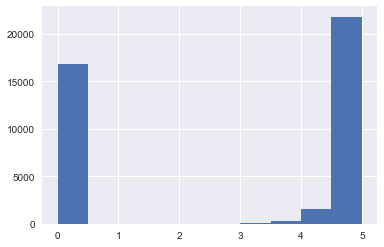

In [6]:
plt.hist(july.overall_satisfaction)
plt.show()

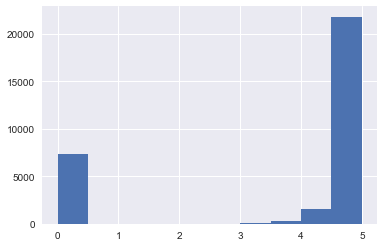

# true 0 ratings: 7290
mean= 3.596307901027198
median= 4.5


In [34]:
zero_raters = july[(july.reviews != 0) & (july.overall_satisfaction == 0)]
july_wo_noratings = july[(july.reviews > 0)]

ratings = july_wo_noratings.overall_satisfaction
july_mean = np.mean(ratings)

plt.hist(ratings)
plt.show()
print('# true 0 ratings:', len(zero_raters.overall_satisfaction))
print('mean=', july_mean)
print('median=', np.median(ratings))

#there are actually quite a few places with a true 0 overall satisfaction rating. 

In [31]:
#we can give the listings with no ratings the benefit of the doubt and set them to the mean
#kind of convoluted since they aren't marked as NaNs, so have to filter out true zeros, replace, then add true zeros back in

july = july[((july.reviews == 0) & (july.overall_satisfaction == 0)) | (july.overall_satisfaction > 0)]
july.overall_satisfaction = july.overall_satisfaction.replace(0, july_mean)

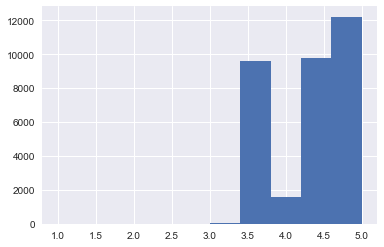

diff = 4.0
mean = 4.393198106020222


In [19]:
ratings = july.overall_satisfaction
rate_diff = np.max(ratings) - np.min(ratings)
plt.hist(ratings)
plt.show()
print('diff =', rate_diff)
print('mean =', np.mean(ratings))

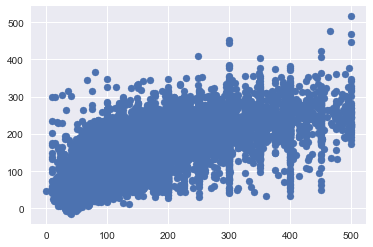

In [23]:
#with true 0 ratings in dataset and no ratings set to the mean
zero_raters = july[(july.reviews != 0) & (july.overall_satisfaction == 0)]
july_wo_noratings = july[(july.reviews > 0)]

ratings = july_wo_noratings.overall_satisfaction
july_mean = np.mean(ratings)

july = july[((july.reviews == 0) & (july.overall_satisfaction == 0)) | (july.overall_satisfaction > 0)]
july.overall_satisfaction = july.overall_satisfaction.replace(0, july_mean)

july = pd.concat([july, zero_raters])

july_y = july.price
july = july.drop(['price', 'latitude', 'longitude'],1)
july_x = pd.get_dummies(july, drop_first=True)

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(july_x)

lm = LinearRegression()
lm.fit(X_train,july_y)
predicted_prices= lm.predict(X_train)

plt.scatter(x=july_y, y=predicted_prices)
plt.show()

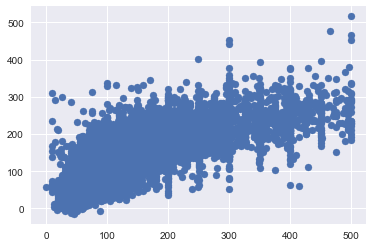

In [3]:
#with all ratings lower than 3 removed (before mean replacement, so this also removes not rated listings)

july = july[july.overall_satisfaction >= 3]
july_y = july.price
july = july.drop(['price', 'latitude', 'longitude'],1)
july_x = pd.get_dummies(july, drop_first=True)

#scaler = preprocessing.MinMaxScaler()
scaler=preprocessing.StandardScaler()
X_train = scaler.fit_transform(july_x)

lm = LinearRegression()
lm.fit(X_train,july_y)
predicted_prices= lm.predict(X_train)

plt.scatter(x=july_y, y=predicted_prices)
plt.show()

In [ ]:
#by standardizing my data and removing outliers (low rated or no-rated, over-priced, and over-roomed listings) I get a much thinner
#prediction graph, with lower priced properties falling along the 1:1 line and the higher priced listings falling below
#the 1:1 line (meaning the lower priced listings are probably more reasonably priced and the higher priced listings are
#probably overpriced)

-3.81843256834e+18


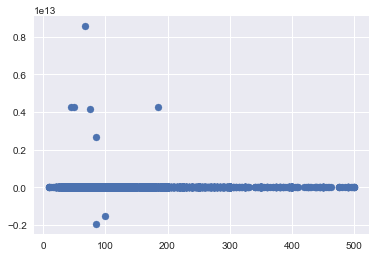

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(july_x, july_y, test_size=.3, random_state=42)

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(Xlr)

linreg = LinearRegression()
# Fit the model on the trainng data.
linreg.fit(X_train, ylr)

X_test = scaler.transform(Xtestlr)
ylr_pred=linreg.predict(X_test)
# Print the r2 score from the testing data.
print(r2_score(ytestlr, ylr_pred))

#plt.ylim( (-50, 500) )
plt.scatter(x=ytestlr, y=ylr_pred)
plt.show()

In [48]:
#There are some out of control predictions that are making the r2 value skyrocket. 
print(min(linreg.coef_))
print(max(linreg.coef_))
#looks like some of our coefficients are crazy large

-8.55427744357e+12
8.55427744354e+12


In [3]:
prop_dict = {}
for prop_type in july.property_type.unique():
    prop_dict[prop_type] = 'Other'

prop_dict['Apartment'] = 'Apartment'
prop_dict['Bed & Breakfast'] = 'Bed & Breakfast'
prop_dict['Serviced Apartment'] = 'Apartment'
prop_dict['Casa particular'] = 'Bed & Breakfast'
prop_dict['Loft'] = 'Loft'
prop_dict['Townhouse'] = 'Townhouse'
prop_dict['Condominium'] = 'Condominium'
prop_dict['House'] = 'House'

july.property_type.replace(prop_dict, inplace=True)

0.573455852762


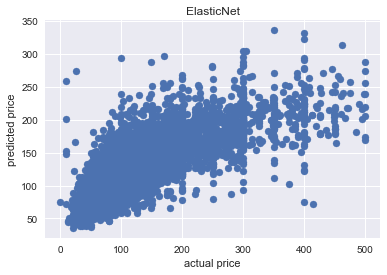

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet

july = july[july.overall_satisfaction >= 3]
july_y = july.price
july_dumb = july.drop(['price', 'latitude', 'longitude'],1)
july_x = pd.get_dummies(july_dumb, drop_first=True)

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(july_x, july_y, test_size=.3, random_state=50)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(Xlr)

elnet = ElasticNet()
# Fit the model on the trainng data.
elnet.fit(X_train, ylr)

X_test = scaler.transform(Xtestlr)
ylr_pred=elnet.predict(X_test)
# Print the r2 score from the testing data.
print(r2_score(ytestlr, ylr_pred))

#plt.ylim( (-100, 1000) )
plt.scatter(x=ytestlr, y=ylr_pred)
plt.title('ElasticNet')
plt.ylabel('predicted price')
plt.xlabel('actual price')
plt.show()

In [4]:
print(min(elnet.coef_))
print(max(elnet.coef_))

-19.6376297377
16.4159946481


In [ ]:
#ElasticNet with StandardScaler did a great job of smoothing the data, and even got rid of our negative predictions. 

In [9]:
coefs = zip(july_x.columns, list(elnet.coef_))

AttributeError: 'zip' object has no attribute 'head'

(array([    4.,     5.,   151.,  3111.,  2965.,   533.,   198.,    80.,
           40.,     8.]),
 array([-249.79183166, -190.53710432, -131.28237699,  -72.02764966,
         -12.77292233,   46.481805  ,  105.73653233,  164.99125966,
         224.24598699,  283.50071432,  342.75544166]),
 <a list of 10 Patch objects>)

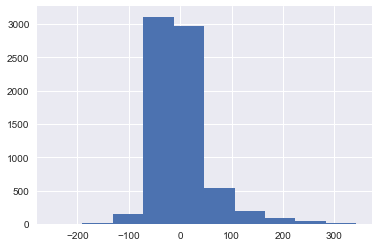

In [21]:
y_residuals=ytestlr-ylr_pred
plt.hist(y_residuals)

In [25]:
X_df = pd.DataFrame(Xtestlr)
X_df['residual'] = y_residuals

X_df.sort_values('residual', ascending=False)

,reviews,overall_satisfaction,accommodates,bedrooms,room_type_Private room,room_type_Shared room,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,...,neighborhood_Woodhaven,neighborhood_Woodlawn,neighborhood_Woodside,property_type_Bed & Breakfast,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,residual
2980,8,3.5,1,1.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,342.755442
2484,8,5.0,2,0.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,329.134025
3568,26,5.0,2,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,325.369656
21898,3,3.5,2,1.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,324.763493
3129,26,4.5,4,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,303.431226
1719,17,5.0,4,2.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,294.351127
3128,4,4.0,8,2.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,292.656145
3085,6,5.0,2,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,287.378754
2181,21,5.0,5,2.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,279.748753
2354,116,5.0,6,2.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,278.097254
